In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 5.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=9b5454205603d8ab4662f78521f9ec08931bfde21587cda6d8516c18bcebb0b3
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install chowtest


In [ ]:
!pip install arch

     |████████████████████████████████| 808kB 5.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
import yfinance as yf
import os
import matplotlib.patches as mpatches
import scipy.stats as stats
from statsmodels.stats import stattools
import statsmodels.api as sm

from chow_test import chowtest
from statsmodels.tsa.stattools import adfuller
import arch

In [ ]:
#downloading NTAP prices: 
start_date = "2000-01-01"
end_date = "2019-12-31"
equity_px = "NTAP"
equity_df = yf.download(equity_px, start_date, end_date, progress=False)

In [ ]:
equity_df.head(10)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,44.93750,45.06250,40.0000,42.500000,35.065536,5426000
2000-01-04,41.18750,42.43750,37.0000,37.125000,30.630770,4511400
2000-01-05,40.37500,42.25000,35.0000,39.187500,32.332481,6633800
2000-01-06,38.50000,38.90625,35.0000,35.031250,28.903280,5589600
2000-01-07,34.50000,42.50000,33.8750,42.500000,35.065536,8510400
2000-01-10,44.28125,45.90625,43.2500,44.312500,36.560970,6348600
2000-01-11,45.50000,46.81250,40.8750,41.250000,34.034195,4730800
2000-01-12,41.00000,44.37500,39.3125,43.562500,35.942177,4356800
2000-01-13,44.00000,45.00000,41.6250,42.859375,35.362041,5144000


In [ ]:
mrkt_df = pd.read_excel('/content/Project Data.xlsx')
mrkt_df.set_index("Calendar Date", inplace=True)
mrkt_df.drop(mrkt_df.tail(1).index, inplace=True)

In [ ]:
mrkt_df['equity px'] = equity_df['Adj Close']
mrkt_df.head()


,Index,1M Tbill Yield,Excess Return on the Market,equity px
Calendar Date,,,,
2000-01-03,3006.741,0.00021,-0.0071,35.065536
2000-01-04,2887.517,0.00021,-0.0406,30.630770
2000-01-05,2884.818,0.00021,-0.0009,32.332481
2000-01-06,2863.497,0.00021,-0.0073,28.903280
2000-01-07,2956.607,0.00021,0.0321,35.065536


In [ ]:
# Calculating log returns for NTAP
array_equity_px = np.array(equity_df["Adj Close"])
equity_log_px = np.log(array_equity_px)
equity_compound_return = equity_log_px[1:len(equity_log_px)] - equity_log_px[0:(len(equity_log_px) - 1)]
# Add zero value as the first element in the array to account for lost value when calculating the return
equity_compound_return = np.insert(equity_compound_return, 0,0)
mrkt_df['equity cont compound return'] = equity_compound_return

In [ ]:
# Calculating log returns for the market data
array_index_px = np.array(mrkt_df['Index'])
index_log_px = np.log(array_index_px)
index_compound_return = index_log_px[1:len(index_log_px)] - index_log_px[0:(len(index_log_px) - 1)]
index_compound_return = np.insert(index_compound_return, 0,0)
mrkt_df['index cont compound return'] = index_compound_return

In [ ]:
# Drop the first row to account for 
mrkt_df.drop(mrkt_df.head(1).index, inplace=True)
mrkt_df.head(10)
len(mrkt_df)

5029

In [ ]:
# define a function for RMRF and Risk free rate data aggregation:

def ffm_data_agg(array_like):
  return(np.prod(1+array_like)-1)


In [ ]:
# Create a dataframe resampling from daily to weekly data
weekly_df = pd.DataFrame() # create new DF
weekly_df['Index'] = mrkt_df['Index'].resample('W', label='right', loffset=pd.Timedelta(days=-2)).mean()
weekly_df['1M TBill Yield'] = mrkt_df['1M Tbill Yield'].resample('W', label='right', loffset=pd.Timedelta(days=-2)).apply(ffm_data_agg)
weekly_df['RMRF'] = mrkt_df['Excess Return on the Market'].resample('W', label= 'right', loffset=pd.Timedelta(days=-2)).apply(ffm_data_agg)
weekly_df['NTAP stock price'] = mrkt_df['equity px'].resample('W', label = 'right', loffset=pd.Timedelta(days=-2)).mean()
weekly_df['NTAP cont compounded return'] = mrkt_df['equity cont compound return'].resample('W', label = 'right', loffset=pd.Timedelta(days=-2)).sum()
weekly_df['index cont compounded return'] = mrkt_df['index cont compound return'].resample('W', label = 'right', loffset=pd.Timedelta(days=-2)).sum()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pa

In [ ]:
weekly_df.drop(weekly_df.tail(1).index, inplace=True)
weekly_df

,Index,1M TBill Yield,RMRF,NTAP stock price,NTAP cont compounded return,index cont compounded return
Calendar Date,,,,,,
2000-01-07,2898.10975,0.00084,-0.017916,31.733017,0.000000,-0.016814
2000-01-14,2984.29340,0.00105,0.020696,36.109767,0.097314,0.021613
2000-01-21,3026.85050,0.00084,0.000378,47.312686,0.223277,0.003606
2000-01-28,2939.70560,0.00105,-0.057084,42.872771,-0.166230,-0.056625
2000-02-04,2960.56700,0.00109,0.044559,46.523715,0.254530,0.046461
...,...,...,...,...,...,...
2019-11-29,9742.35925,0.00024,0.011301,57.772747,-0.010507,0.011270
2019-12-06,9665.89100,0.00035,0.000981,56.462633,0.007236,0.001099
2019-12-13,9765.07640,0.00035,0.007377,58.178553,0.035572,0.007124


In [ ]:
weekly_df.head(2)

,Index,1M TBill Yield,RMRF,NTAP stock price,NTAP cont compounded return,index cont compounded return
Calendar Date,,,,,,
2000-01-07,2898.10975,0.00084,-0.017916,31.733017,0.000000,-0.016814
2000-01-14,2984.29340,0.00105,0.020696,36.109767,0.097314,0.021613


In [ ]:
print(weekly_df['NTAP cont compounded return'].describe())
print('NTAP cont compounded return skewness: {}'.format(weekly_df['NTAP cont compounded return'].skew()))
print('NTAP cont compounded return excess kurtosis: {}'.format(weekly_df['NTAP cont compounded return'].kurtosis()))

count    1043.000000
mean        0.000484
std         0.077085
min        -0.461750
25%        -0.031434
50%         0.002850
75%         0.035061
max         0.480235
Name: NTAP cont compounded return, dtype: float64
NTAP cont compounded return skewness: -0.09548795354296993
NTAP cont compounded return excess kurtosis: 5.3793990159691205


In [ ]:
print(weekly_df['index cont compounded return'].describe())
print('index cont compounded return skewness: {}'.format(weekly_df['index cont compounded return'].skew()))
print('index cont compounded return excess kurtosis: {}'.format(weekly_df['index cont compounded return'].kurtosis()))

count    1043.000000
mean        0.001156
std         0.024861
min        -0.203254
25%        -0.010326
50%         0.002864
75%         0.014728
max         0.122622
Name: index cont compounded return, dtype: float64
index cont compounded return skewness: -0.9770045896347991
index cont compounded return excess kurtosis: 7.828976510797274


In [ ]:
print(weekly_df['1M TBill Yield'].describe())
print('1M TBill Yield skewness: {}'.format(weekly_df['1M TBill Yield'].skew()))
print('1M TBill Yield excess kurtosis: {}'.format(weekly_df['1M TBill Yield'].kurtosis()))

count    1043.000000
mean        0.000310
std         0.000349
min         0.000000
25%         0.000000
50%         0.000200
75%         0.000450
max         0.001301
Name: 1M TBill Yield, dtype: float64
1M TBill Yield skewness: 1.070812929985293
1M TBill Yield excess kurtosis: 0.03675808332309094


## Part I Normality:


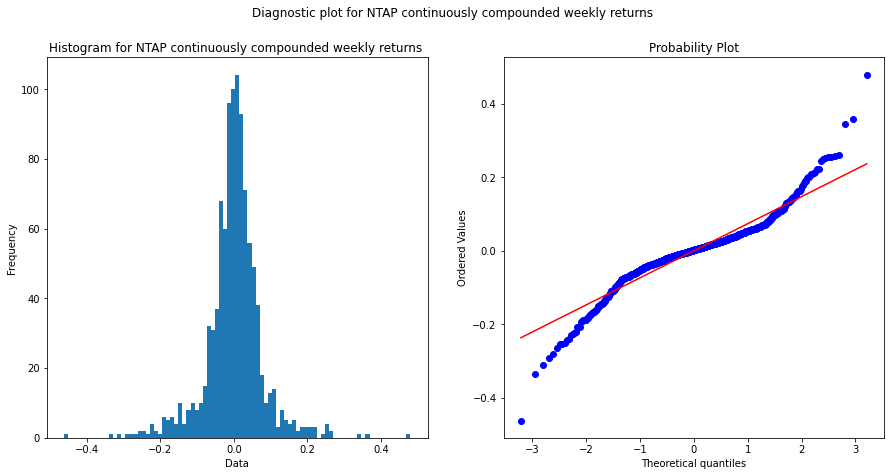

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Diagnostic plot for NTAP continuously compounded weekly returns')
ax1.hist(weekly_df['NTAP cont compounded return'], bins=85)
ax1.set_title("Histogram for NTAP continuously compounded weekly returns ")
ax1.set_xlabel('Data')
ax1.set_ylabel('Frequency')

fig.ax2 = stats.probplot(weekly_df['NTAP cont compounded return'], dist='norm', plot=plt)

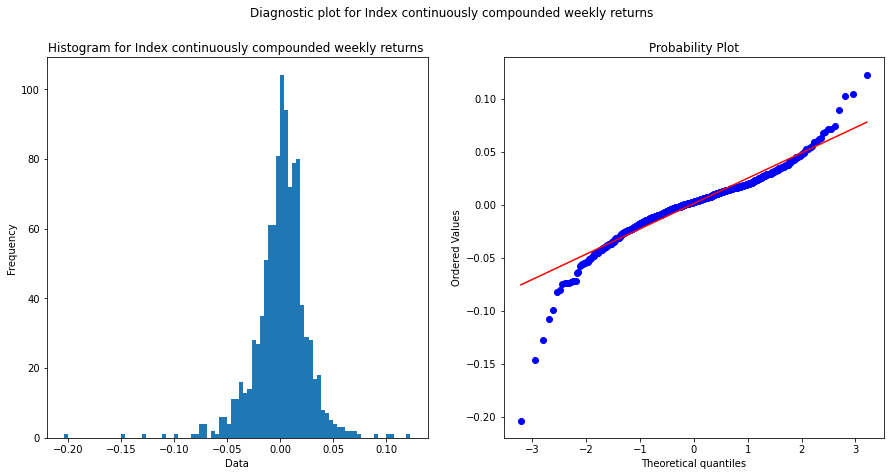

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Diagnostic plot for Index continuously compounded weekly returns')
ax1.hist(weekly_df['index cont compounded return'], bins=85)
ax1.set_title("Histogram for Index continuously compounded weekly returns ")
ax1.set_xlabel('Data')
ax1.set_ylabel('Frequency')
fig.ax2 = stats.probplot(weekly_df['index cont compounded return'], dist='norm', plot=plt)

In [ ]:
## Applying JB test for NTAP returns: 
jarque_bera_test_equity = stats.jarque_bera(weekly_df['NTAP cont compounded return'])
jarque_bera_test_equity

# Output: in the output, first stat is test statistic for the hypothesis test and the second stat is the p-value for the hypothesis test

(1244.4895190573302, 0.0)

In [ ]:
## Applying JB test for index returns: 
jarque_bera_test_index = stats.jarque_bera(weekly_df['index cont compounded return'])
jarque_bera_test_index
# Output: in the output, first stat is test statistic for the hypothesis test and the second stat is the p-value for the hypothesis test

(2799.8055442484265, 0.0)

In [ ]:
stattools.jarque_bera(weekly_df['NTAP cont compounded return'])

(1244.4895190573302,
 5.788080245110699e-271,
 -0.09535057177089173,
 8.347898374266267)

In [ ]:
stattools.jarque_bera(weekly_df['index cont compounded return'])

(2799.8055442484265, 0.0, -0.9755989398447223, 10.785748679640502)

## Part II CAPM 

In [ ]:
# calculate asset excess return:
weekly_df['asset excess return'] = weekly_df['NTAP cont compounded return'] - weekly_df['1M TBill Yield']

In [ ]:
weekly_df.head()

,Index,1M TBill Yield,RMRF,NTAP stock price,NTAP cont compounded return,index cont compounded return,asset excess return
Calendar Date,,,,,,,
2000-01-07,2898.10975,0.00084,-0.017916,31.733017,0.000000,-0.016814,-0.000840
2000-01-14,2984.29340,0.00105,0.020696,36.109767,0.097314,0.021613,0.096263
2000-01-21,3026.85050,0.00084,0.000378,47.312686,0.223277,0.003606,0.222436
2000-01-28,2939.70560,0.00105,-0.057084,42.872771,-0.166230,-0.056625,-0.167280
2000-02-04,2960.56700,0.00109,0.044559,46.523715,0.254530,0.046461,0.253439


In [ ]:
# preparing data to input it into the modeL: 
X = weekly_df['RMRF']
y = weekly_df['asset excess return']
# adding constant for the regression analysis
X = sm.add_constant(X)

In [ ]:

# Creating model object
capm = sm.OLS(y,X)
results = capm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     asset excess return   R-squared:                       0.292
Model:                             OLS   Adj. R-squared:                  0.291
Method:                  Least Squares   F-statistic:                     428.8
Date:                 Sun, 18 Apr 2021   Prob (F-statistic):           4.81e-80
Time:                         17:41:04   Log-Likelihood:                 1373.2
No. Observations:                 1043   AIC:                            -2742.
Df Residuals:                     1041   BIC:                            -2733.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -0.909      0.364      -0.006       0.002
RMRF           1.6922      0.082     20.708      0.000       1.532       1.853
==============================================================================
Omnibus:                      126.039   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1165.722
Skew:                           0.056   Prob(JB):                    7.36e-254
Kurtosis:                       8.178   Cond. No.                         40.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
weekly_df

,Index,1M TBill Yield,RMRF,NTAP stock price,NTAP cont compounded return,index cont compounded return,asset excess return
Calendar Date,,,,,,,
2000-01-07,2898.10975,0.00084,-0.017916,31.733017,0.000000,-0.016814,-0.000840
2000-01-14,2984.29340,0.00105,0.020696,36.109767,0.097314,0.021613,0.096263
2000-01-21,3026.85050,0.00084,0.000378,47.312686,0.223277,0.003606,0.222436
2000-01-28,2939.70560,0.00105,-0.057084,42.872771,-0.166230,-0.056625,-0.167280
2000-02-04,2960.56700,0.00109,0.044559,46.523715,0.254530,0.046461,0.253439
...,...,...,...,...,...,...,...
2019-11-29,9742.35925,0.00024,0.011301,57.772747,-0.010507,0.011270,-0.010747
2019-12-06,9665.89100,0.00035,0.000981,56.462633,0.007236,0.001099,0.006886
2019-12-13,9765.07640,0.00035,0.007377,58.178553,0.035572,0.007124,0.035222


## Part III Chow test and predictive failure test:

In [ ]:
# Model 1 (before 2008):
weekly_df_before_2008 = weekly_df.loc[:'2007-12-31']
# preparing data to input it into the modeL: 
X_before_2008 = weekly_df_before_2008['RMRF']
y_before_2008 = weekly_df_before_2008['asset excess return']
# adding constant for the regression analysis
X_before_2008 = sm.add_constant(X_before_2008)

In [ ]:
# Creating model object
capm_before_2008 = sm.OLS(y_before_2008,X_before_2008)
results_before_2008 = capm_before_2008.fit()
# Deriving RSS for model 1:
RSS_before_2008 = sum(results_before_2008.resid**2)
print(RSS_before_2008)

3.1773355839429653


In [ ]:
# Creating model object for subset #2
weekly_df_after_2008 = weekly_df.loc['2008-01-01':]
# preparing data to input it into the modeL: 
X_after_2008 = weekly_df_after_2008['RMRF']
y_after_2008 = weekly_df_after_2008['asset excess return']
# adding constant for the regression analysis
X_after_2008 = sm.add_constant(X_after_2008)

In [ ]:
# Creating model object
capm_after_2008 = sm.OLS(y_after_2008,X_after_2008)
results_after_2008 = capm_after_2008.fit()
# Deriving RSS for model 1:
RSS_after_2008 = sum(results_after_2008.resid**2)
print(RSS_after_2008)

0.9260380310124026


In [ ]:
# Deriving RSS for the whole model:
RSS_total_model = sum(results.resid**2)
print(RSS_total_model)

4.387543713254204


In [ ]:
# Deriving the test statistic for Chow test:
chow_test_stat = ((RSS_total_model - (RSS_before_2008 + RSS_after_2008))/(RSS_before_2008 + RSS_after_2008))*((len(weekly_df) - 4)/2)
print('Chow test statistic is: {}'.format(chow_test_stat))

Chow test statistic is: 35.97682782971522


In [ ]:
# Calculating the test stat for Predictive Failure test:
predictive_failure_test_stat = ((RSS_total_model - RSS_before_2008)/RSS_before_2008)*((len(weekly_df_before_2008) - 2)/(len(weekly_df) - len(weekly_df_before_2008)))
print('Failure predictive test stat is: {}'.format(predictive_failure_test_stat))

Failure predictive test stat is: 0.2525054421933141


In [ ]:
weekly_df.head(2)

,Index,1M TBill Yield,RMRF,NTAP stock price,NTAP cont compounded return,index cont compounded return,asset excess return
Calendar Date,,,,,,,
2000-01-07,2898.10975,0.00084,-0.017916,31.733017,0.000000,-0.016814,-0.000840
2000-01-14,2984.29340,0.00105,0.020696,36.109767,0.097314,0.021613,0.096263


## Part IV: ACF and PACF of NTAP continuously compounded returns

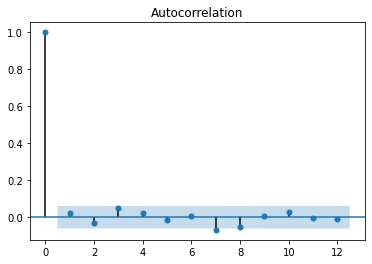

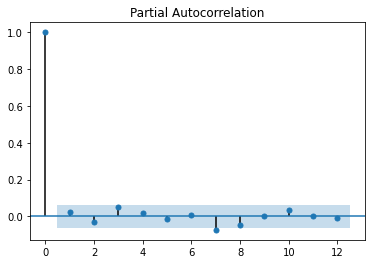

In [ ]:
sm.graphics.tsa.plot_acf(weekly_df['NTAP cont compounded return'], lags=12)
sm.graphics.tsa.plot_pacf(weekly_df['NTAP cont compounded return'], lags=12)
plt.show()

## Part V: ARMA model with different lag length:

In [ ]:
# arma_cpi_model_1 = sm.tsa.ARMA(cpi_index_secondDiff, order=(4,0))
# arma_cpi_model_1_fit = arma_cpi_model_1.fit()
# print(arma_cpi_model_1_fit.summary())

ntap_stock_px_model_4 = sm.tsa.ARMA(weekly_df['NTAP cont compounded return'], order=(4,4))
ntap_stock_px_model_4_fit = ntap_stock_px_model_4.fit()
print(ntap_stock_px_model_4_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                                   ARMA Model Results                                  
Dep. Variable:     NTAP cont compounded return   No. Observations:                 1043
Model:                              ARMA(4, 4)   Log Likelihood                1201.282
Method:                                css-mle   S.D. of innovations              0.076
Date:                         Sun, 18 Apr 2021   AIC                          -2382.564
Time:                                 19:42:07   BIC                          -2333.065
Sample:                             01-07-2000   HQIC                         -2363.789
                                  - 12-27-2019                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.0005      0.002      0.209      0.834      -0.004   

In [ ]:
# PRep data for the model: 
weekly_df.head(2)

,Index,1M TBill Yield,RMRF,NTAP stock price,NTAP cont compounded return,index cont compounded return
Calendar Date,,,,,,
2000-01-07,2898.10975,0.00084,-0.017916,31.733017,0.000000,-0.016814
2000-01-14,2984.29340,0.00105,0.020696,36.109767,0.097314,0.021613


In [ ]:
ntap_log_return = np.log(weekly_df['NTAP stock price']).diff()[1:]
for i in ['nc', 'c', 'ct']:
    result = adfuller(ntap_log_return,  autolag = 'AIC',  regression = i)
    print('ADF Statistic with %s for NTAP log return: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('Critical values for NTAP log return at the 1 %, 5 %, and 10 % levels')
    print((result[4]))
    print('')

ADF Statistic with nc for NTAP log return: -15.138457
p-value: 0.000000
Critical values for NTAP log return at the 1 %, 5 %, and 10 % levels
{'1%': -2.5678973162039047, '5%': -1.94126186207361, '10%': -1.6165666195593897}

ADF Statistic with c for NTAP log return: -15.131196
p-value: 0.000000
Critical values for NTAP log return at the 1 %, 5 %, and 10 % levels
{'1%': -3.4366655541494944, '5%': -2.8643284548748533, '10%': -2.5682546880209087}

ADF Statistic with ct for NTAP log return: -15.157141
p-value: 0.000000
Critical values for NTAP log return at the 1 %, 5 %, and 10 % levels
{'1%': -3.9675181809205284, '5%': -3.4147280995326987, '10%': -3.1295446070150224}



In [ ]:
# Model_3

ntap_stock_px_model_3 = sm.tsa.ARMA(weekly_df['NTAP cont compounded return'], order=(3,3))
ntap_stock_px_model_3_fit = ntap_stock_px_model_3.fit()
print(ntap_stock_px_model_3_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


                                   ARMA Model Results                                  
Dep. Variable:     NTAP cont compounded return   No. Observations:                 1043
Model:                              ARMA(3, 3)   Log Likelihood                1198.558
Method:                                css-mle   S.D. of innovations              0.077
Date:                         Sun, 18 Apr 2021   AIC                          -2381.115
Time:                                 19:45:58   BIC                          -2341.517
Sample:                             01-07-2000   HQIC                         -2366.096
                                  - 12-27-2019                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.0005      0.002      0.200      0.841      -0.004   

In [ ]:
# Model_2

ntap_stock_px_model_2 = sm.tsa.ARMA(ntap_log_return, order=(2,2))
ntap_stock_px_model_2_fit = ntap_stock_px_model_2.fit()
print(ntap_stock_px_model_2_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:       NTAP stock price   No. Observations:                 1042
Model:                     ARMA(2, 2)   Log Likelihood                1417.609
Method:                       css-mle   S.D. of innovations              0.062
Date:                Mon, 19 Apr 2021   AIC                          -2823.217
Time:                        02:35:56   BIC                          -2793.524
Sample:                    01-14-2000   HQIC                         -2811.954
                         - 12-27-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0006      0.003      0.249      0.803      -0.004       0.006
ar.L1.NTAP stock price     0.0524      0.214      0.245      0.806      -0.367       0.472
ar.L

## Part V: ARMA model with different lag length:

In [ ]:
# Prepare data for further input into the model:
ntap_log_return = np.log(weekly_df['NTAP stock price']).diff()[1:]

# Check for stationarity
for i in ['nc', 'c', 'ct']:
    result = adfuller(ntap_log_return,  autolag = 'AIC',  regression = i)
    print('ADF Statistic with %s for NTAP log return: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('Critical values for NTAP log return at the 1 %, 5 %, and 10 % levels')
    print((result[4]))
    print('')

ADF Statistic with nc for NTAP log return: -15.138457
p-value: 0.000000
Critical values for NTAP log return at the 1 %, 5 %, and 10 % levels
{'1%': -2.5678973162039047, '5%': -1.94126186207361, '10%': -1.6165666195593897}

ADF Statistic with c for NTAP log return: -15.131196
p-value: 0.000000
Critical values for NTAP log return at the 1 %, 5 %, and 10 % levels
{'1%': -3.4366655541494944, '5%': -2.8643284548748533, '10%': -2.5682546880209087}

ADF Statistic with ct for NTAP log return: -15.157141
p-value: 0.000000
Critical values for NTAP log return at the 1 %, 5 %, and 10 % levels
{'1%': -3.9675181809205284, '5%': -3.4147280995326987, '10%': -3.1295446070150224}



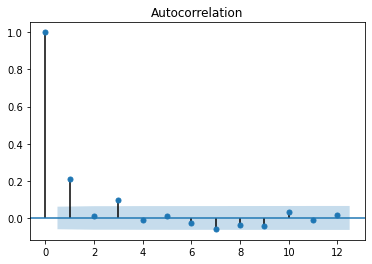

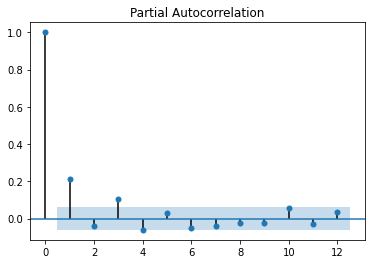

In [ ]:
sm.graphics.tsa.plot_acf(ntap_log_return, lags=12)
sm.graphics.tsa.plot_pacf(ntap_log_return, lags=12)
plt.show()

In [ ]:
# Run models and report ICs:
# Model 4 (lag lenght 4)
ntap_stock_px_model_4 = sm.tsa.ARMA(ntap_log_return, order=(4,4))
ntap_stock_px_model_4_fit = ntap_stock_px_model_4.fit()
print(ntap_stock_px_model_4_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:       NTAP stock price   No. Observations:                 1042
Model:                     ARMA(4, 4)   Log Likelihood                1432.657
Method:                       css-mle   S.D. of innovations              0.061
Date:                Mon, 19 Apr 2021   AIC                          -2845.313
Time:                        02:37:42   BIC                          -2795.824
Sample:                    01-14-2000   HQIC                         -2826.542
                         - 12-27-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0004      0.002      0.217      0.828      -0.003       0.004
ar.L1.NTAP stock price     0.2334      0.068      3.415      0.001       0.099       0.367
ar.L

In [ ]:
# Model 3 (lag lenght 3)
ntap_stock_px_model_3 = sm.tsa.ARMA(ntap_log_return, order=(3,3))
ntap_stock_px_model_3_fit = ntap_stock_px_model_3.fit()
print(ntap_stock_px_model_3_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:       NTAP stock price   No. Observations:                 1042
Model:                     ARMA(3, 3)   Log Likelihood                1427.007
Method:                       css-mle   S.D. of innovations              0.062
Date:                Mon, 19 Apr 2021   AIC                          -2838.014
Time:                        02:39:30   BIC                          -2798.423
Sample:                    01-14-2000   HQIC                         -2822.997
                         - 12-27-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0006      0.003      0.247      0.805      -0.004       0.006
ar.L1.NTAP stock price    -1.2965      0.223     -5.814      0.000      -1.734      -0.859
ar.L

In [ ]:
# Model 2 (lag lenght 2)
ntap_stock_px_model_2 = sm.tsa.ARMA(ntap_log_return, order=(2,2))
ntap_stock_px_model_2_fit = ntap_stock_px_model_2.fit()
print(ntap_stock_px_model_2_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:       NTAP stock price   No. Observations:                 1042
Model:                     ARMA(2, 2)   Log Likelihood                1417.609
Method:                       css-mle   S.D. of innovations              0.062
Date:                Mon, 19 Apr 2021   AIC                          -2823.217
Time:                        02:40:16   BIC                          -2793.524
Sample:                    01-14-2000   HQIC                         -2811.954
                         - 12-27-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0006      0.003      0.249      0.803      -0.004       0.006
ar.L1.NTAP stock price     0.0524      0.214      0.245      0.806      -0.367       0.472
ar.L

In [ ]:
# Model 1 (lag lenght 1)
ntap_stock_px_model_1 = sm.tsa.ARMA(ntap_log_return, order=(1,1))
ntap_stock_px_model_1_fit = ntap_stock_px_model_1.fit()
print(ntap_stock_px_model_1_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:       NTAP stock price   No. Observations:                 1042
Model:                     ARMA(1, 1)   Log Likelihood                1414.696
Method:                       css-mle   S.D. of innovations              0.062
Date:                Mon, 19 Apr 2021   AIC                          -2821.392
Time:                        02:41:24   BIC                          -2801.597
Sample:                    01-14-2000   HQIC                         -2813.883
                         - 12-27-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0006      0.002      0.260      0.795      -0.004       0.005
ar.L1.NTAP stock price    -0.3662      0.101     -3.611      0.000      -0.565      -0.167
ma.L

In [ ]:
# Model 0 (lag lenght 0)
ntap_stock_px_model_0 = sm.tsa.ARMA(ntap_log_return, order=(0,0))
ntap_stock_px_model_0_fit = ntap_stock_px_model_0.fit()
print(ntap_stock_px_model_0_fit.summary())

                              ARMA Model Results                              
Dep. Variable:       NTAP stock price   No. Observations:                 1042
Model:                     ARMA(0, 0)   Log Likelihood                1385.819
Method:                           css   S.D. of innovations              0.064
Date:                Mon, 19 Apr 2021   AIC                          -2767.639
Time:                        02:42:22   BIC                          -2757.741
Sample:                    01-14-2000   HQIC                         -2763.884
                         - 12-27-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.300      0.764      -0.003       0.004


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


## Part 7: ARMA(1,1)-GARCH(1,1) model:

In [ ]:
# Start by fitting the ARMA(1,1) model:
ntap_stock_px_model_1 = sm.tsa.ARMA(ntap_log_return, order=(1,1))
ntap_stock_px_model_1_fit = ntap_stock_px_model_1.fit()
# Fit GARCH(1,1) model:
ntap_log_return_garch_model = arch.arch_model(ntap_stock_px_model_1_fit.resid**2, p=1, q=1,vol='Garch', mean='zero',  rescale=False).fit()
ntap_log_return_garch_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -4055.2131300245574
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4055.2131373089487
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                4055.21
Distribution:                  Normal   AIC:                          -8104.43
Method:            Maximum Likelihood   BIC:                          -8089.58
                                        No. Observations:                 1042
Date:                Mon, Apr 19 2021   Df Residuals:                     1042
Time:                        05:13:26   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5495e-06  1.465e-10  1.740e+04      0.000 [2.549e-06,2.550e-06]
alpha[1]       0.2000  5.585e-02      3.581  3.424e-04   [9.053e-02,  0.309]
beta[1]        0.7800  3.232e-02     24.130 1.201e-128     [  0.717,  0.843]
============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

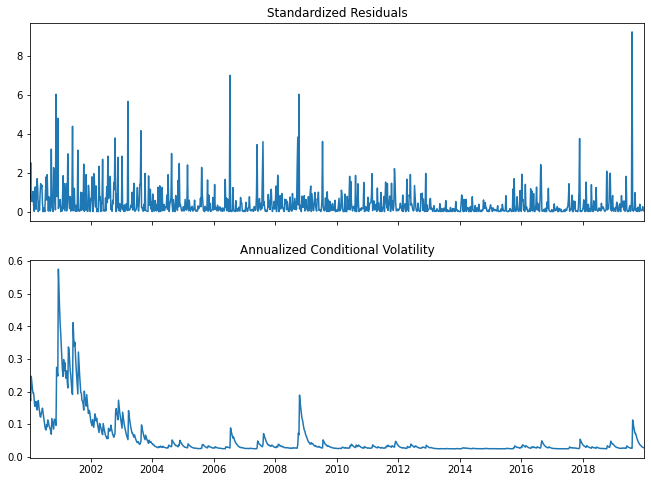

In [ ]:
# Plotting the conditional variance:
fig = ntap_log_return_garch_model.plot(annualize='W')
fig.set_size_inches(11,8)